
# Real Estate Economy


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RESOURCE_ID = "5bbe6c55-bce6-4edb-9d04-68edeb6bf7b1"   # WPRDC Property Sales Transactions
YEAR_MIN = 2020                                      # Use 2020–present
WEIGHT_PRICE = 0.6
WEIGHT_TURNOVER = 0.4

# Load from WPRDC (works in JupyterHub)
url = f"https://data.wprdc.org/datastore/dump/{RESOURCE_ID}"
df_raw = pd.read_csv(url)

# Keep required columns
df = df_raw[['MUNIDESC', 'SALEDATE', 'PRICE']].dropna(subset=['MUNIDESC','SALEDATE','PRICE']).copy()
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'], errors='coerce')
df = df.dropna(subset=['SALEDATE'])
df = df[df['SALEDATE'].dt.year >= YEAR_MIN].copy()
df.head()


/scratch/slurm-25031/ipykernel_1610718/3643945476.py:12: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(url)


,MUNIDESC,SALEDATE,PRICE
0,South Park,2022-06-21,1.0
4,1st Ward - PITTSBURGH,2023-04-28,44100.0
5,1st Ward - PITTSBURGH,2023-04-28,1719.0
8,10th Ward - PITTSBURGH,2022-05-31,1.0
10,12th Ward - PITTSBURGH,2023-12-16,26500.0


In [2]:

# Convert ward strings -> neighborhood (split at ' - ' and take right side)
df['NEIGHBORHOOD_RAW'] = df['MUNIDESC'].astype(str).str.split(' - ').str[-1].str.strip()

def normalize_name(name: str) -> str:
    if not isinstance(name, str):
        return name
    s = name.strip().lower()
    # Drop municipal prefixes/suffixes
    for pref in ['city of ', 'borough of ', 'township of ']:
        if s.startswith(pref):
            s = s[len(pref):]
    for suf in [' borough', ' township']:
        if s.endswith(suf):
            s = s[:-len(suf)]
    # Common small fixes
    s = s.replace(' mt ', ' mount ')
    if s.startswith('mt '): s = 'mount ' + s[3:]
    s = s.replace(' st. ', ' saint ').replace(' st ', ' saint ')
    # Collapse multiple spaces
    s = ' '.join(s.split())
    # Title case
    t = ' '.join(w.capitalize() for w in s.split())
    # Improve Mc/Mac capitalization
    def fix_mc(word):
        if word.startswith('Mc') and len(word) > 2:
            return 'Mc' + word[2:].lower().capitalize()
        if word.startswith('Mac') and len(word) > 3:
            return 'Mac' + word[3:].lower().capitalize()
        return word
    t = ' '.join(fix_mc(w) for w in t.split())
    # Explicit replacements (add more if your team shares a canonical list)
    replacements = {
        'Pgh': 'Pittsburgh',
        'Mckeesport': 'McKeesport',
        'Mt Oliver': 'Mount Oliver',
    }
    return replacements.get(t, t)

# Apply and keep a report of how names changed
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD_RAW'].map(normalize_name)
alignment_report = (
    df[['NEIGHBORHOOD_RAW','NEIGHBORHOOD']]
      .drop_duplicates()
      .sort_values(['NEIGHBORHOOD','NEIGHBORHOOD_RAW'])
)
alignment_report.head(10)


,NEIGHBORHOOD_RAW,NEIGHBORHOOD
14350,Aleppo,Aleppo
250699,Aspinwall,Aspinwall
187112,Avalon,Avalon
87,Baldwin Boro,Baldwin Boro
252092,Baldwin Twp,Baldwin Twp
251071,Bell Acres,Bell Acres
197427,Bellevue,Bellevue
251105,Ben Avon,Ben Avon
268838,Ben Avon Heights,Ben Avon Heights
348,Bethel Park,Bethel Park


In [3]:

# Ensure PRICE numeric
df['PRICE'] = pd.to_numeric(df['PRICE'], errors='coerce')
df = df.dropna(subset=['PRICE'])

# Aggregate by final neighborhood
agg = (
    df.groupby('NEIGHBORHOOD')
      .agg(sales_count=('PRICE','size'),
           median_price=('PRICE','median'))
      .reset_index()
)

# Normalize helpers
def minmax(x):
    x = x.astype(float)
    return (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else np.zeros_like(x, dtype=float)

# Build score: higher price = good; fewer sales = good
agg['price_norm'] = minmax(agg['median_price'])
agg['turnover_inv'] = 1 / agg['sales_count']
agg['turnover_norm'] = minmax(agg['turnover_inv'])
agg['real_estate_economy_score'] = WEIGHT_PRICE*agg['price_norm'] + WEIGHT_TURNOVER*agg['turnover_norm']

# Final results
result = agg[['NEIGHBORHOOD','sales_count','median_price','real_estate_economy_score']]           .sort_values('real_estate_economy_score', ascending=False)

result.head(10)


,NEIGHBORHOOD,sales_count,median_price,real_estate_economy_score
34,Edgeworth,291,650000.0,0.619131
100,Sewickley Heights,136,622500.0,0.615675
43,Fox Chapel,655,645800.0,0.604555
113,Trafford,14,119500.0,0.510116
8,Ben Avon Heights,41,361300.0,0.469910
101,Sewickley Hills,135,425000.0,0.433601
53,Haysville,17,100000.0,0.421499
86,Pine,2610,415000.0,0.385019
14,Bradford Woods,168,367500.0,0.372353
65,Marshall,2079,388520.0,0.361115


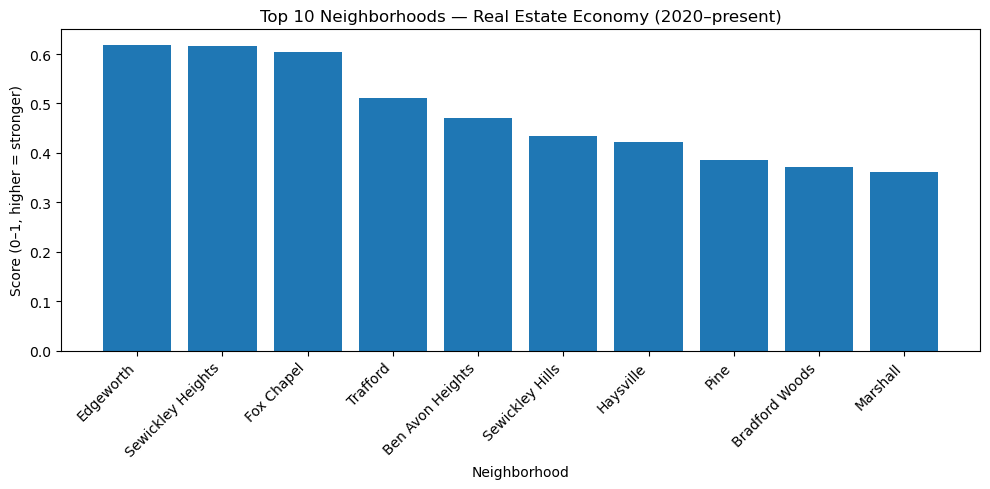

,NEIGHBORHOOD,sales_count,median_price,real_estate_economy_score
34,Edgeworth,291,650000.0,0.619131
100,Sewickley Heights,136,622500.0,0.615675
43,Fox Chapel,655,645800.0,0.604555
113,Trafford,14,119500.0,0.510116
8,Ben Avon Heights,41,361300.0,0.469910
101,Sewickley Hills,135,425000.0,0.433601
53,Haysville,17,100000.0,0.421499
86,Pine,2610,415000.0,0.385019
14,Bradford Woods,168,367500.0,0.372353
65,Marshall,2079,388520.0,0.361115


In [4]:

# Top 10 viz + table
top10 = result.head(10)

plt.figure(figsize=(10,5))
plt.bar(top10['NEIGHBORHOOD'], top10['real_estate_economy_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Neighborhoods — Real Estate Economy (2020–present)')
plt.xlabel('Neighborhood')
plt.ylabel('Score (0–1, higher = stronger)')
plt.tight_layout()
plt.show()

top10[['NEIGHBORHOOD','sales_count','median_price','real_estate_economy_score']]


In [6]:

# Exports for team merge + audit trail
merge_csv = 'real_estate_economy_by_neighborhood.csv'
result[['NEIGHBORHOOD','real_estate_economy_score']].to_csv(merge_csv, index=False)

report_csv = 'real_estate_economy_alignment_report.csv'
alignment_report.to_csv(report_csv, index=False)

merge_csv, report_csv

result[['NEIGHBORHOOD','real_estate_economy_score']].to_csv('real_estate_economy_simple.csv', index=False)